In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from toolz.curried import curry, pipe

from simulator import CahnHilliard2D
from chnet.ch_generator import init_norm

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

# device = torch.device("cpu")
device = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data


cropper = return_slice(cutoff=5)


def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
    # plt.savefig('figures/foo.png' if title is None else "figures/"+title, bbox_inches='tight')
    plt.show()
    
    
def corr(x_data, y_data):
    return pipe(x_data, 
                lambda x: np.fft.fftn(x, axes=(0,1)), 
                lambda x: x * np.conj(np.fft.fftn(y_data, axes=(0,1))), 
                lambda x: np.fft.ifftn(x),
                lambda x: np.fft.fftshift(x), 
                lambda x: x.real) / x_data.size

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw
Using device: cuda:1


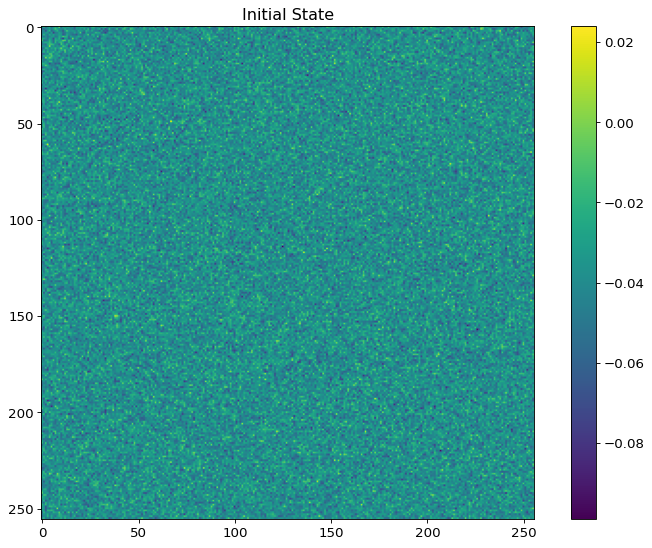

In [3]:
nsamples = 4096
dim_x = 256
seed = 42
m_l = -0.15
m_r = 0.15
gamma = 1.
dx = 0.25
dt = 0.01

init_data = init_norm(nsamples, dim_x, dim_x, seed=seed, m_l=m_l, m_r=m_r)  
draw_im(init_data[0], title="Initial State")

sim = CahnHilliard2D(gamma=gamma, dx=dx, dt=dt, device="cuda:0")

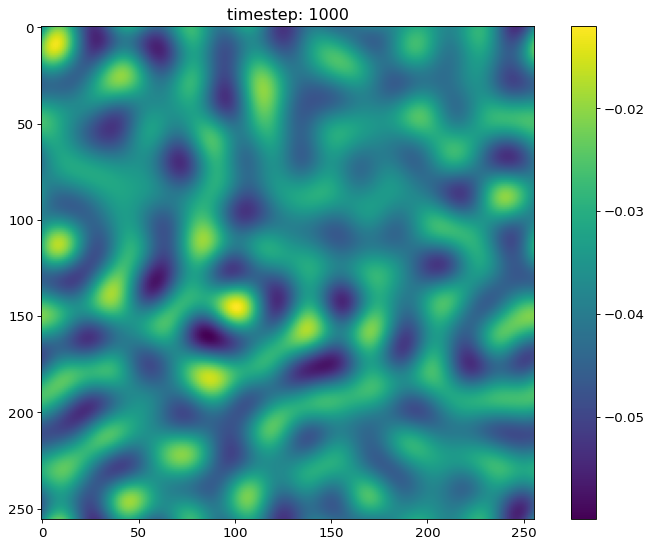

In [4]:
X_1k = sim.forward(init_data, n_steps=1000)
draw_im(X_1k[0], title="timestep: 1000")

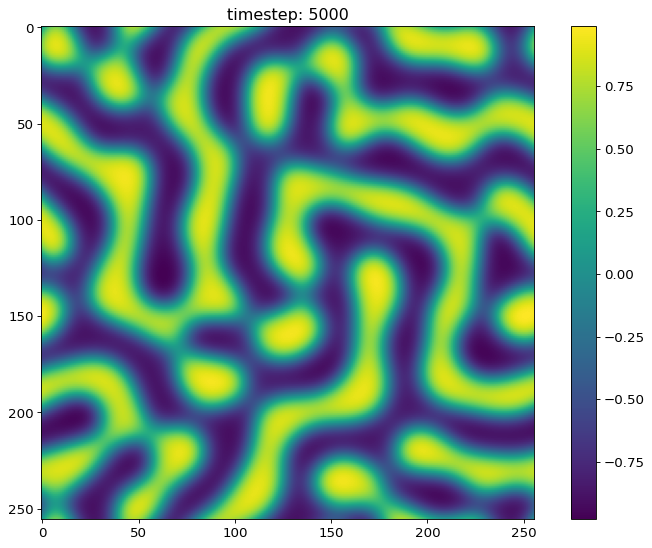

In [5]:
X_5k = sim.forward(X_1k, n_steps=4000)
draw_im(X_5k[0], title="timestep: 5000")

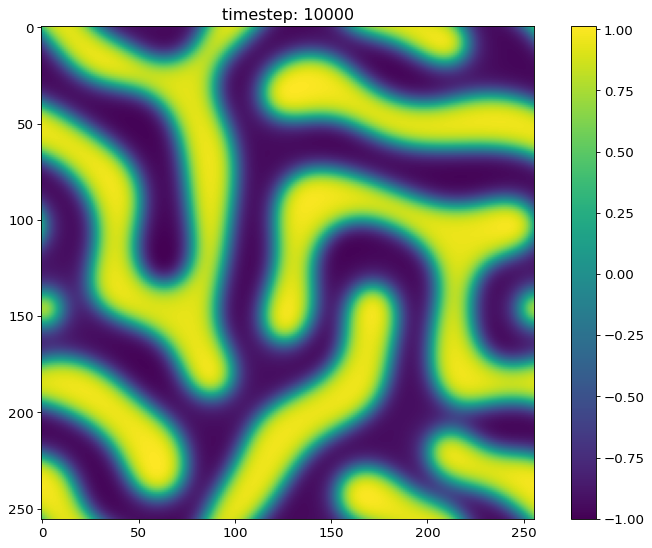

In [6]:
X_10k = sim.forward(X_5k, n_steps=5000)
draw_im(X_10k[0], title="timestep: 10000")

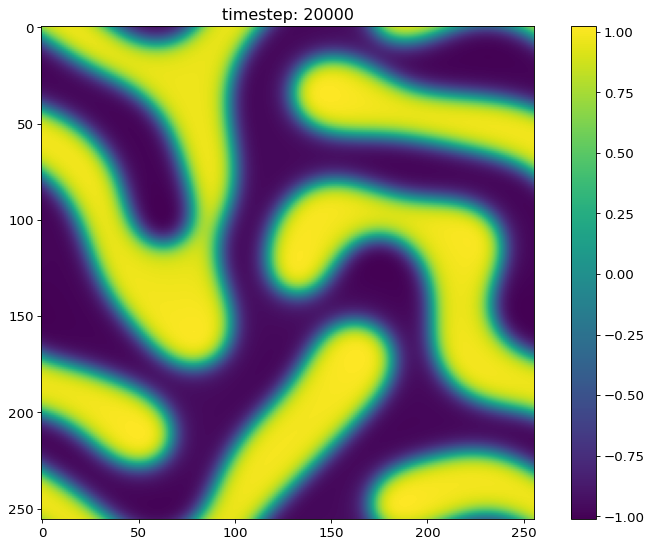

In [10]:
X_20k = sim.forward(X_10k, n_steps=10000)
draw_im(X_20k[0], title="timestep: 20000")